In [103]:
import torch
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from show_hands import show_hands

In [104]:
current_directory = os.getcwd()
data_directory = os.path.join(current_directory, 'Poker data')
train_data_file = os.path.join(data_directory, 'poker-hand-training-true.csv')
train_data = pd.read_csv(train_data_file)

test_data_file = os.path.join(data_directory, 'poker-hand-testing.csv')
test_data = pd.read_csv(test_data_file)

In [123]:
train_dummy_data = pd.get_dummies(train_data, columns=train_data.columns[0:10:2]).head(8000)
test_dummy_data = pd.get_dummies(test_data, columns=test_data.columns[0:10:2]).head(2000)
labels = list(train_dummy_data.columns)
labels.pop(5)
print(labels)

['C1', 'C2', 'C3', 'C4', 'C5', 'S1_1', 'S1_2', 'S1_3', 'S1_4', 'S2_1', 'S2_2', 'S2_3', 'S2_4', 'S3_1', 'S3_2', 'S3_3', 'S3_4', 'S4_1', 'S4_2', 'S4_3', 'S4_4', 'S5_1', 'S5_2', 'S5_3', 'S5_4']


In [124]:
X_train = train_dummy_data[labels].to_numpy()
y_train = train_dummy_data['Class'].to_numpy()
X_test = train_dummy_data[labels].to_numpy()
y_test = train_dummy_data['Class'].to_numpy()

In [125]:
len(X_train)

8000

In [126]:
X_train

array([[10, 11, 13, ...,  0,  0,  0],
       [11, 13, 10, ...,  1,  0,  0],
       [12, 11, 13, ...,  0,  1,  0],
       ...,
       [ 1,  6,  4, ...,  1,  0,  0],
       [ 6, 12, 10, ...,  0,  1,  0],
       [ 2,  2, 13, ...,  0,  0,  0]], dtype=int64)

In [127]:
y_train

array([9, 9, 9, ..., 3, 1, 1], dtype=int64)

In [128]:
def dataloading (X, y):
    arr = []
    for i in range(len(X)):
        features = torch.Tensor(X[i])
        label = float(y[i])
        combined = (features,label)
        arr.append(combined)
    return arr
train = []
test =[]
train = dataloading(X_train,y_train)
test = dataloading(X_test,y_test)

In [129]:
import torch.nn as nn
model = nn.Sequential(nn.Linear(25,20),nn.ReLU(),nn.Linear(20,15),nn.Linear(15,10),nn.ReLU())
loss = nn.CrossEntropyLoss()
stepsize = 0.1 
optimizermlp = torch.optim.SGD(model.parameters(), lr=stepsize)

In [130]:
batchsize = 20
from torch.utils import data
train_loader = data.DataLoader(train, batch_size=batchsize, shuffle=True)
test_loader = data.DataLoader(test,batch_size=batchsize, shuffle=True)

In [131]:
def accuracy(y_hat, y):
    """Compute the number of correct predictions."""
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(axis=1)
    cmp = y_hat.type(y.dtype) == y
    return float(cmp.type(y.dtype).sum())

In [132]:
def evaluate_accuracy(net, data_iter):  #@save
    """Compute the accuracy for a model on a dataset."""
    net.eval()  # Set the model to evaluation mode
    accuracy_metric = 0
    y_len = 0
    with torch.no_grad():
        for X, y in data_iter:
            accuracy_metric = accuracy_metric + accuracy(net(X),y)
            y_len = y_len + y.numel()
    return accuracy_metric/ y_len

In [133]:
def train_epoch(net, train_iter, loss, updater):  #@save
    """The training loop defined in Chapter 3."""
    # Set the model to training mode
    net.train()
    # Sum of training loss, sum of training accuracy, no. of examples
    loss_val = 0
    acc_val = 0
    y_len = 0
    for X, y in train_iter:
        # Compute gradients and update parameters
        y_hat = net(X) 
        l = loss(y_hat, y.long())
        # Using PyTorch in-built optimizer & loss criterion
        updater.zero_grad()
        l.backward()
        updater.step()
        loss_val = loss_val + float(l)*len(y)
        acc_val  = acc_val  + accuracy(y_hat, y)
        y_len = y_len + y.numel()
    # Return training loss and training accuracy
    return loss_val/y_len, acc_val/y_len

In [134]:
def train_network(net, train_iter, test_iter, loss, num_epochs, optimizer):  #@save
#    animator = Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0.3, 0.9],
#                        legend=['train loss', 'train acc', 'test acc'])
    loss_vals = []
    acc_train = []
    acc_test = []
    for epoch in range(num_epochs):
        train_metrics = train_epoch(net, train_loader, loss, optimizer)
        test_acc = evaluate_accuracy(net, test_loader)
        loss_vals.append(train_metrics[0])
        acc_train.append(train_metrics[1])
        acc_test.append(test_acc)
        if (epoch % 5) == 0 and epoch > 0:
            print("Loss function value at epoch "+str(epoch)+": "+str(train_metrics[0]))
    return loss_vals, acc_train, acc_test

In [135]:
num_epochs = 20
loss_vals, acc_train, acc_test = train_network(model, train_loader, test_loader, loss, num_epochs, optimizermlp)

Loss function value at epoch 5: 1.0054971262812615
Loss function value at epoch 10: 0.9987490327656269
Loss function value at epoch 15: 0.9755916541814804


In [136]:
loss_vals

[1.364544491171837,
 1.047050975561142,
 1.0154989477992058,
 1.0038165086507798,
 1.0056183417141438,
 1.0054971262812615,
 1.0021622391045093,
 1.000949172526598,
 0.9975418737530708,
 0.998717340528965,
 0.9987490327656269,
 0.9867799539864063,
 0.9783566652238369,
 0.9778149718046188,
 0.9758160553872586,
 0.9755916541814804,
 0.9720712576806545,
 0.9703095234930516,
 0.9738147775828838,
 0.9706979332864285]

(0.2, 1.2)

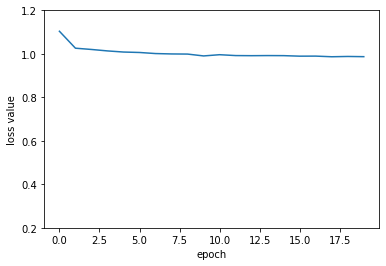

In [162]:
plt.plot(loss_vals)
plt.xlabel('epoch')
plt.ylabel('loss value')
plt.ylim([0.2, 1.2])

In [137]:
def plot_loss_accuracy(loss_vals, acc_train, acc_test):
    fmts=('-', 'r--', 'g-.')
    plt.plot(range(1,len(loss_vals)+1),loss_vals,fmts[0])
    plt.plot(range(1,len(loss_vals)+1),acc_train,fmts[1])
    plt.plot(range(1,len(loss_vals)+1),acc_test,fmts[2])
    plt.legend(['train loss','train acc','test acc'])
    return

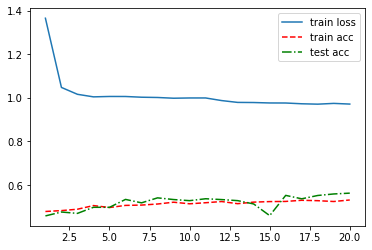

In [138]:
plot_loss_accuracy(loss_vals, acc_train, acc_test)

In [139]:
print("Accuracy on training set: %f"
      % (evaluate_accuracy(model, train_loader)))
print("Accuracy on test set: %f"
      % (evaluate_accuracy(model, test_loader)))

Accuracy on training set: 0.562000
Accuracy on test set: 0.562000


In [147]:
import torch.nn as nn
model = nn.Sequential(nn.Linear(25,15),nn.ReLU(),nn.Linear(15,10),nn.ReLU())
loss = nn.CrossEntropyLoss()
stepsize = 0.1 
optimizermlp = torch.optim.SGD(model.parameters(), lr=stepsize)

In [148]:
batchsize = 20
from torch.utils import data
train_loader = data.DataLoader(train, batch_size=batchsize, shuffle=True)
test_loader = data.DataLoader(test,batch_size=batchsize, shuffle=True)

In [149]:
def accuracy(y_hat, y):
    """Compute the number of correct predictions."""
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(axis=1)
    cmp = y_hat.type(y.dtype) == y
    return float(cmp.type(y.dtype).sum())

In [150]:
def evaluate_accuracy(net, data_iter):  #@save
    """Compute the accuracy for a model on a dataset."""
    net.eval()  # Set the model to evaluation mode
    accuracy_metric = 0
    y_len = 0
    with torch.no_grad():
        for X, y in data_iter:
            accuracy_metric = accuracy_metric + accuracy(net(X),y)
            y_len = y_len + y.numel()
    return accuracy_metric/ y_len

In [151]:
def train_epoch(net, train_iter, loss, updater):  #@save
    """The training loop defined in Chapter 3."""
    # Set the model to training mode
    net.train()
    # Sum of training loss, sum of training accuracy, no. of examples
    loss_val = 0
    acc_val = 0
    y_len = 0
    for X, y in train_iter:
        # Compute gradients and update parameters
        y_hat = net(X) 
        l = loss(y_hat, y.long())
        # Using PyTorch in-built optimizer & loss criterion
        updater.zero_grad()
        l.backward()
        updater.step()
        loss_val = loss_val + float(l)*len(y)
        acc_val  = acc_val  + accuracy(y_hat, y)
        y_len = y_len + y.numel()
    # Return training loss and training accuracy
    return loss_val/y_len, acc_val/y_len

In [152]:
def train_network(net, train_iter, test_iter, loss, num_epochs, optimizer):  #@save
#    animator = Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0.3, 0.9],
#                        legend=['train loss', 'train acc', 'test acc'])
    loss_vals = []
    acc_train = []
    acc_test = []
    for epoch in range(num_epochs):
        train_metrics = train_epoch(net, train_loader, loss, optimizer)
        test_acc = evaluate_accuracy(net, test_loader)
        loss_vals.append(train_metrics[0])
        acc_train.append(train_metrics[1])
        acc_test.append(test_acc)
        if (epoch % 5) == 0 and epoch > 0:
            print("Loss function value at epoch "+str(epoch)+": "+str(train_metrics[0]))
    return loss_vals, acc_train, acc_test

In [153]:
num_epochs = 20
loss_vals, acc_train, acc_test = train_network(model, train_loader, test_loader, loss, num_epochs, optimizermlp)

Loss function value at epoch 5: 1.0062876597046853
Loss function value at epoch 10: 0.9960532633960247
Loss function value at epoch 15: 0.9893221917748451


In [154]:
loss_vals

[1.1038834883272648,
 1.0259692671895027,
 1.020166127383709,
 1.0134897743165494,
 1.008330789655447,
 1.0062876597046853,
 1.0013395214080811,
 0.9995454286038875,
 0.998934099972248,
 0.9904153472185135,
 0.9960532633960247,
 0.9920701287686825,
 0.9915628871321678,
 0.9920554822683334,
 0.9917292048037052,
 0.9893221917748451,
 0.989605952501297,
 0.9866282115876674,
 0.9879843175411225,
 0.9870276573300362]

(0.2, 1.2)

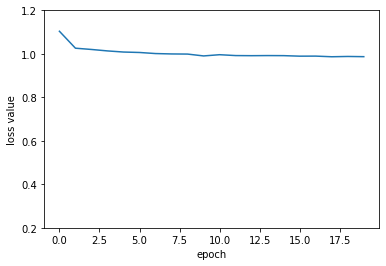

In [161]:
plt.plot(loss_vals)
plt.xlabel('epoch')
plt.ylabel('loss value')
plt.ylim([0.2, 1.2])

In [156]:
def plot_loss_accuracy(loss_vals, acc_train, acc_test):
    fmts=('-', 'r--', 'g-.')
    plt.plot(range(1,len(loss_vals)+1),loss_vals,fmts[0])
    plt.plot(range(1,len(loss_vals)+1),acc_train,fmts[1])
    plt.plot(range(1,len(loss_vals)+1),acc_test,fmts[2])
    plt.legend(['train loss','train acc','test acc'])
    return

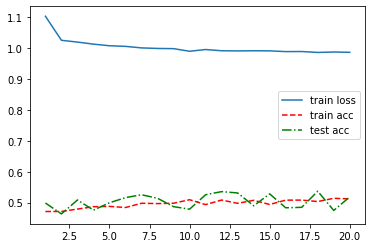

In [158]:
plot_loss_accuracy(loss_vals, acc_train, acc_test)

In [157]:
print("Accuracy on training set: %f"
      % (evaluate_accuracy(model, train_loader)))
print("Accuracy on test set: %f"
      % (evaluate_accuracy(model, test_loader)))

Accuracy on training set: 0.518750
Accuracy on test set: 0.518750
